### **1. IMPORTING LIBRARIES AND DATASET**

In [14]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Replace 'your_file.csv' with the path to your dataset
df = pd.read_csv('sales_data.csv')

### **2. TASK 1: DATA CLEANING**

**Handling Missing Values**

In [3]:
missing_values = df.isnull().sum()
missing_values

,0
Customer ID,0
Order ID,0
Order Date,0
Product ID,0
Product Name,0
Category,0
Quantity,0
Unit Price,0
Region,0
Total Amount,0


**Handling Data Format, Dublicates, Data types and Outliers**

In [4]:
# Standardize the date format
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')  # Convert to datetime format, coerce errors

# Remove duplicate records
df = df.drop_duplicates()

# Ensure correct data types
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Total Amount'] = pd.to_numeric(df['Total Amount'], errors='coerce')

# Remove outliers (optional but recommended for analysis)
df = df[df['Quantity'] > 0]

# Final cleaned dataset
cleaned_df = df.copy()
cleaned_df.head(3)

,Customer ID,Order ID,Order Date,Product ID,Product Name,Category,Quantity,Unit Price,Region,Total Amount
0,8a80ddb1-8615-4452-adce-db56c9385365,d929f0c8-5600-456b-9360-ae114e339871,2021-12-25,9c485900-229d-4b96-ac99-374754d40e1c,T-shirt,Accessories,2,55.23,North,110.46
1,ac664d43-893a-47a1-bdd7-139f73a360a7,38d57142-b1f3-4b25-ae2e-e7404d2df736,2022-10-08,3ff68652-ba71-4610-9284-71f778fd2819,Smartphone,Clothing,1,217.55,South,217.55
2,ebbc4ba3-d24f-4e25-a585-15c8e6bacbd7,58a7f2a2-5682-4510-b94e-cb56d076880d,2022-11-30,99ad1f2f-fa2e-4b27-8952-7b23249eeebc,T-shirt,Books,5,145.57,West,727.85


### **3. TASK2: CUSTOMER SEGMENTATION**

**Dataframe Preparation**

In [5]:
# Creating seprate dataframe for customer segmentation
customer_seg = pd.DataFrame()
customer_seg['Customer ID'] = cleaned_df['Customer ID']

# Calculate Recency (days since last purchase)
recency = datetime.now() - cleaned_df['Order Date']
recency = recency.dt.days
customer_seg['Recency'] = recency

# Calculate Frequency (total number of orders)
frequency = cleaned_df.groupby('Customer ID').size()
customer_seg['Frequency'] = cleaned_df['Customer ID'].map(frequency)

# Calculate Monetary Value (total amount spent)
monetary = cleaned_df.groupby('Customer ID')['Total Amount'].sum()
customer_seg['Monetary'] = cleaned_df['Customer ID'].map(monetary)

customer_seg.head(2)

,Customer ID,Recency,Frequency,Monetary
0,8a80ddb1-8615-4452-adce-db56c9385365,989,1,110.46
1,ac664d43-893a-47a1-bdd7-139f73a360a7,702,1,217.55


In [6]:
customer_seg['R_rank'] = customer_seg['Recency'].rank(ascending=True, method= 'min')
customer_seg['F_rank']=customer_seg['Frequency'].rank(ascending=False, method= 'min')
customer_seg['M_rank']=customer_seg['Monetary'].rank(ascending=False, method= 'min')
customer_seg['R_score'] = pd.cut(customer_seg['R_rank'], bins=5, labels=[5, 4, 3, 2, 1], include_lowest=True).astype(int)
customer_seg['F_score'] = pd.cut(customer_seg['F_rank'], bins=5, labels=[5, 4, 3, 2, 1], include_lowest=True).astype(int)
customer_seg['M_score'] = pd.cut(customer_seg['M_rank'], bins=5, labels=[5, 4, 3, 2, 1], include_lowest=True).astype(int)

customer_seg.head(2)

,Customer ID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_score,F_score,M_score
0,8a80ddb1-8615-4452-adce-db56c9385365,989,1,110.46,286.0,1.0,345.0,2,3,1
1,ac664d43-893a-47a1-bdd7-139f73a360a7,702,1,217.55,162.0,1.0,320.0,3,3,1


**Final Customer Segmentation**

In [7]:
#Initialization of final DF
Final_customer_seg = pd.DataFrame()
Final_customer_seg['Customer ID'] = customer_seg['Customer ID']

#Function which will segment customer based on their behaviour
def segment_customer(df):
    if df['R_score'] > 3 and df['M_score'] >= 3 : # High Recency and Monetary
        return 'High-Value Customer'
    elif df['R_score'] < 3 and df['M_score'] > 3:  # High Monetary but low Recency
        return 'Big Spender'
    elif df['R_score'] > 3:  # High Recency
        return 'Recent Customer'
    elif df['R_score'] < 3:  # Low Recency
        return 'At-Risk Customer'
    else:
        return 'Other'

Final_customer_seg['Customer Segment'] = customer_seg.apply(segment_customer, axis=1)
Final_customer_seg.head()

,Customer ID,Customer Segment
0,8a80ddb1-8615-4452-adce-db56c9385365,At-Risk Customer
1,ac664d43-893a-47a1-bdd7-139f73a360a7,Other
2,ebbc4ba3-d24f-4e25-a585-15c8e6bacbd7,Recent Customer
3,5f3f88e8-b638-4cfd-9af8-e14b63d9082f,Recent Customer
4,2029cf6c-dd8e-430c-ae24-586d3a5f422a,High-Value Customer


In [24]:
Final_customer_seg['Customer Segment'].value_counts(normalize=True)*100


,proportion
Customer Segment,
At-Risk Customer,23.140496
High-Value Customer,22.865014
Other,20.110193
Recent Customer,17.079890
Big Spender,16.804408


**Customer Segmentation Graph**

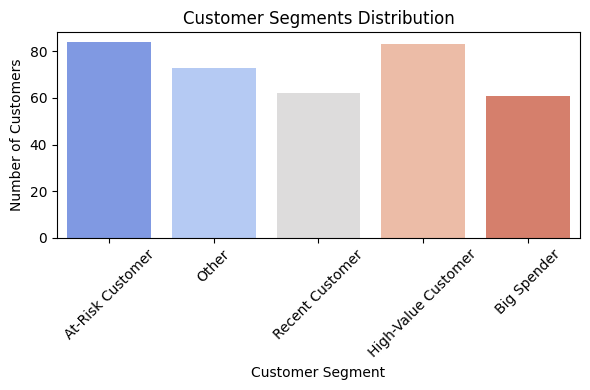

In [15]:
# 4. Bar Chart for Customer Segments Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Customer Segment', data=Final_customer_seg, palette='coolwarm')
plt.title('Customer Segments Distribution')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **4. TASK3: SALES TREND ANALYSIS**

**Sales Data Preparation**

In [17]:
#Initializing Sales Dataframe
sales_df = df.copy()
sales_df = sales_df.drop(columns=['Customer ID', 'Order ID'])

In [19]:
# Convert 'Order Date' to datetime for easy grouping and analysis
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'])

# Extract year and month for analysis
sales_df['Year'] = sales_df['Order Date'].dt.year
sales_df['Month'] = sales_df['Order Date'].dt.month

# 1. Monthly Sales Trend
monthly_sales = sales_df.groupby(['Year', 'Month'])['Total Amount'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(Day=1))  # Combine year and month into a date
monthly_sales = monthly_sales[['Date', 'Total Amount']].sort_values('Date')

# 2. Yearly Sales Trend
yearly_sales = sales_df.groupby('Year')['Total Amount'].sum().reset_index()

# 3. Best Performing Product Categories
category_performance = sales_df.groupby('Category')['Total Amount'].sum().reset_index().sort_values(by='Total Amount', ascending=False)

# 4. Regions with Highest Sales
region_sales = sales_df.groupby('Region')['Total Amount'].sum().reset_index().sort_values(by='Total Amount', ascending=False)

**Sales Trend Visualization**

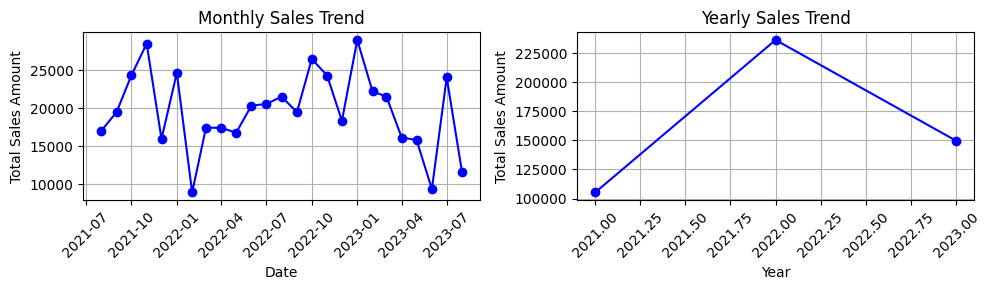

In [20]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# 1. Line Chart for Monthly Sales Trend
ax[0].plot(monthly_sales['Date'], monthly_sales['Total Amount'], marker='o', color='b')
ax[0].set_title('Monthly Sales Trend')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Total Sales Amount')
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

# 2. Line Chart for Yearly Sales Trend
ax[1].plot(yearly_sales['Year'], yearly_sales['Total Amount'], marker='o', color='b')
ax[1].set_title('Yearly Sales Trend')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Total Sales Amount')
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()

# Display the subplots
plt.show()


**Category Performance Visualization**

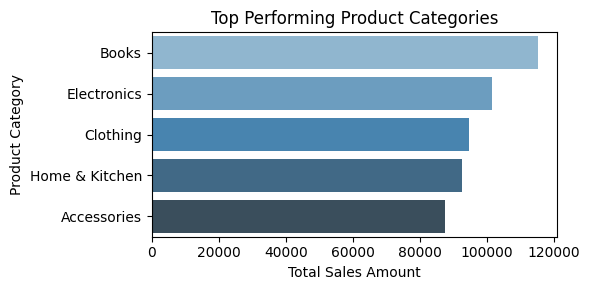

In [21]:
# 3. Bar Chart for Top Product Categories
plt.figure(figsize=(6, 3))
sns.barplot(x='Total Amount', y='Category', data=category_performance, palette='Blues_d')
plt.title('Top Performing Product Categories')
plt.xlabel('Total Sales Amount')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


**Regional Sales visualization**

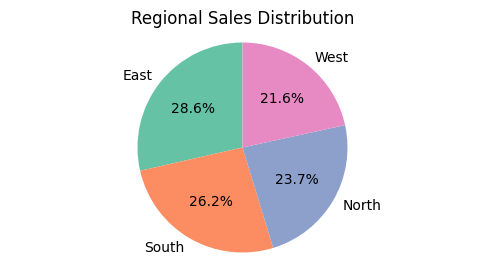

In [22]:
# 4. Pie Chart for Regional Sales Distribution
plt.figure(figsize=(6, 3))
plt.pie(region_sales['Total Amount'], labels=region_sales['Region'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
plt.title('Regional Sales Distribution')
plt.axis('equal')  # Ensures that pie chart is drawn as a circle
plt.show()
